Matplotlib created a temporary cache directory at /tmp/matplotlib-6ouuvdx_ because the default path (/home/atomics/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[Qibo 0.2.3|INFO|2024-04-03 01:53:06]: Loading platform icarusq_rd_sq_a11
[Qibo 0.2.3|INFO|2024-04-03 01:53:06]: Connecting to instrument <qibolab.instruments.icarusqfpga.RFSOC_RO object at 0x7fc2e895f910>.
[Qibo 0.2.3|INFO|2024-04-03 01:53:06]: Connected to board2, version: 2-1.8qbchip.0.0
[Qibo 0.2.3|INFO|2024-04-03 01:53:06]: Connecting to instrument <qibolab.instruments.icarusq.MCAttenuator object at 0x7fc241170b20>.
100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


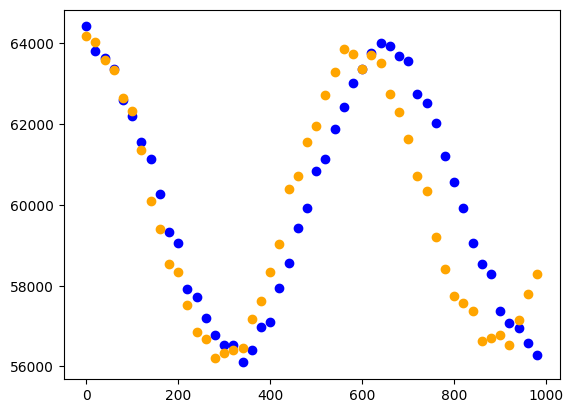

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from qibolab import create_platform, ExecutionParameters, AveragingMode, AcquisitionType
from qibolab.pulses import Pulse, ReadoutPulse, PulseSequence, Drag
from tqdm import tqdm

# Setting execution parameters
opts = ExecutionParameters(
    nshots=1000,  # Number of shots
    relaxation_time=200e3,  # Qubit relaxation time in ns
    acquisition_type=AcquisitionType.INTEGRATION,  # Type of acquisition
    averaging_mode=AveragingMode.SEQUENTIAL  # Averaging mode
)

# Creating platform and connecting
platform = create_platform("icarusq_rd_sq_a11")
platform.connect()

# Creating readout pulses for qubits 6 and 7
q6_ro = platform.create_qubit_readout_pulse(5, 0)
q7_ro = platform.create_qubit_readout_pulse(6, 0)

# Creating pi pulses for qubits 6 and 7
q6_pi_pulse = platform.create_RX_pulse(qubit=5, start=5)
q7_pi_pulse = platform.create_RX_pulse(qubit=6, start=5)

######################################################
# Q6 CRTL Q7 TARGET

# Creating control pulse
CR_pulse = q7_pi_pulse.copy()
CR_pulse.channel = q6_pi_pulse.channel

# Setting up pulse lengths for Rabi experiment
rabi_pulse_length = np.arange(0, 1000, 20)

# Initializing arrays for results
crtl_gnd_results = np.zeros(len(rabi_pulse_length))
crtl_exc_results = np.zeros(len(rabi_pulse_length))

# Creating pulse sequence for ground state
ps = PulseSequence(*[CR_pulse, q7_ro])

# Performing Rabi experiment for ground state
for idx, t in enumerate(tqdm(rabi_pulse_length)):
    CR_pulse.duration = t
    q7_ro.start = CR_pulse.finish
    crtl_gnd_results[idx] = platform.execute_pulse_sequence(ps, opts)[q7_ro.serial].magnitude

# Adding pi pulse for excitation
ps.add(q6_pi_pulse)
CR_pulse.start = q6_pi_pulse.finish

# Performing Rabi experiment for excited state
for idx, t in enumerate(tqdm(rabi_pulse_length)):
    CR_pulse.duration = t
    q7_ro.start = CR_pulse.finish
    crtl_exc_results[idx] = platform.execute_pulse_sequence(ps, opts)[q7_ro.serial].magnitude

# Plotting results
plt.scatter(rabi_pulse_length, crtl_gnd_results, color="blue")
plt.scatter(rabi_pulse_length, crtl_exc_results, color="orange")
plt.savefig('rabi.png')  # Saving plot as image file

np.save('crtl_gnd_results.npy',crtl_gnd_results)
np.save('crtl_exc_results.npy', crtl_exc_results)
np.save('rabi_pulse_length.npy', rabi_pulse_length)